In [ ]:
#Paul's original code:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as pr_auc

# Load the dataset
url = 'https://raw.githubusercontent.com/marhcouto/fraud-detection/master/data/card_transdata.csv?raw=true'
data = pd.read_csv(url)

# Print the top and bottom 5 rows
print(data.head(5))
print(data.tail(5))
print("")

# Split the data into features (independent variables) and the target variable (default or not)
X = data.drop('loan_status', axis=1)
y = data['loan_status']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict probabilities for the test data
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc_score = pr_auc(recall, precision)

# Calculate Gini coefficient
gini = 2 * roc_auc - 1

# Calculate KS statistic
ks = max(tpr - fpr)

# Print the results
print(f"ROC AUC: {roc_auc:.2f}")
print(f"PR AUC: {pr_auc_score:.2f}")
print(f"Gini: {gini:.2f}")
print(f"KS: {ks:.2f}")

# Create a lift chart
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 1, len(tpr)), tpr, label='Cumulative Response')
plt.plot(np.linspace(0, 1, len(fpr)), fpr, label='Cumulative Non-Response')
plt.xlabel('Fraction of Sample')
plt.ylabel('Cumulative Percentage')
plt.title('Lift Chart')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
y_pred = (y_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy:.2f}")
print("")
print("Confusion Matrix:")
print(confusion)
print("")
print("Classification Report:")
print(classification_rep)


# **Project Assignment #6: Comparative Analysis of Fraud Detection Models**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

## **Step 0: Upload the Data and Exploratory Data Analysis (EDA)**

After making some iterations we decided to work only with 10% of the dataset to run the whole model before to continue with the 100% of the data because could take and also was doing 1 in all performance metrics

Step 0: Data Loading and EDA
Dataset shape: (100000, 8)

Columns in dataset:
['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']

First few rows:
        distance_from_home  distance_from_last_transaction  \
516187           19.179396                        0.178758   
419611           47.192898                        1.224832   
955905           54.389043                        5.290910   
739350            3.129745                        0.607212   
54077             0.925275                        2.238057   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
516187                        2.979353              1.0        0.0   
419611                        0.293538              1.0        1.0   
955905                        4.492304              1.0        1.0   
739350                        0.357527              1.0        0.0   
54077           

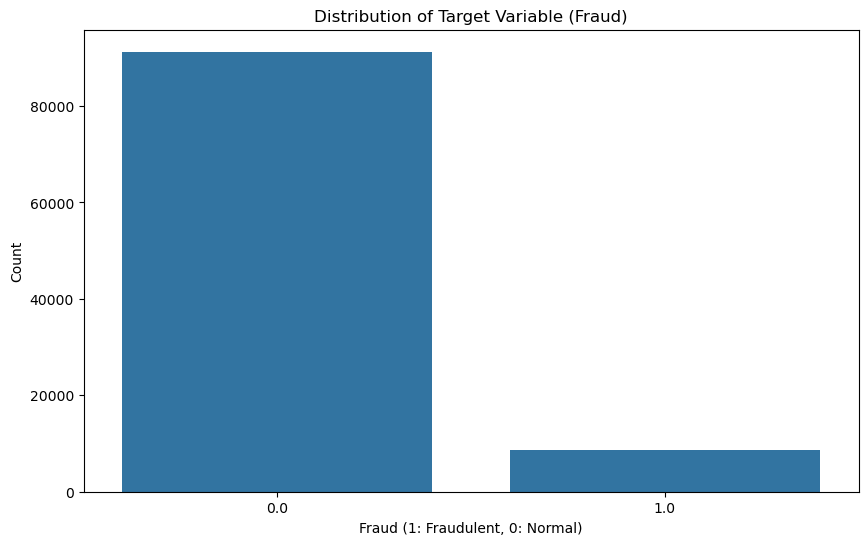

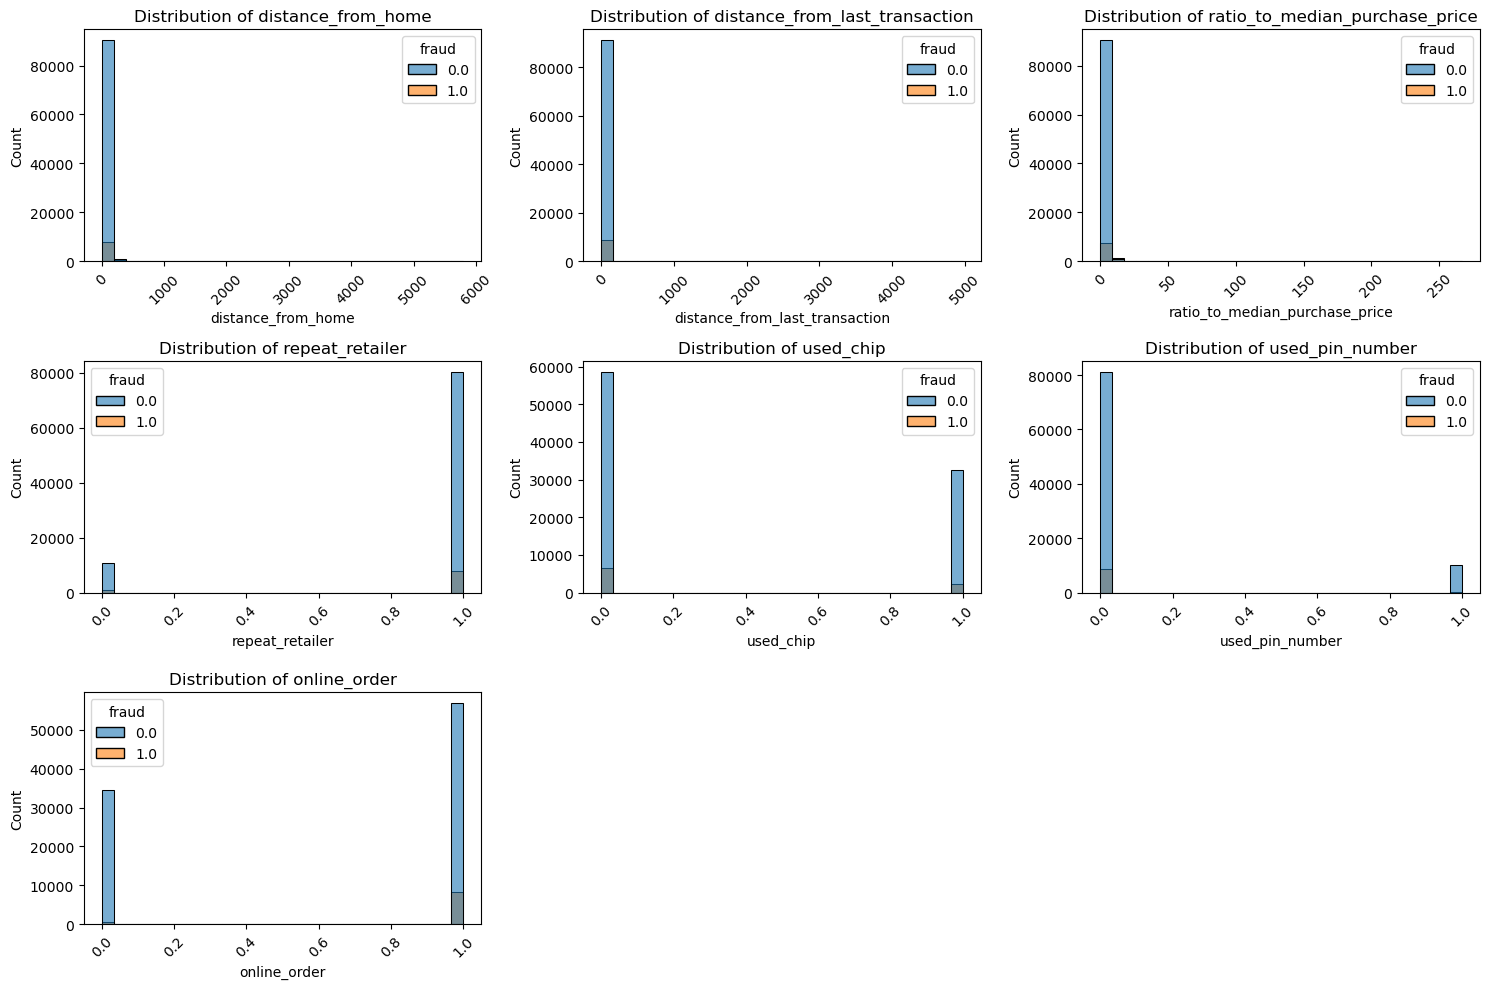

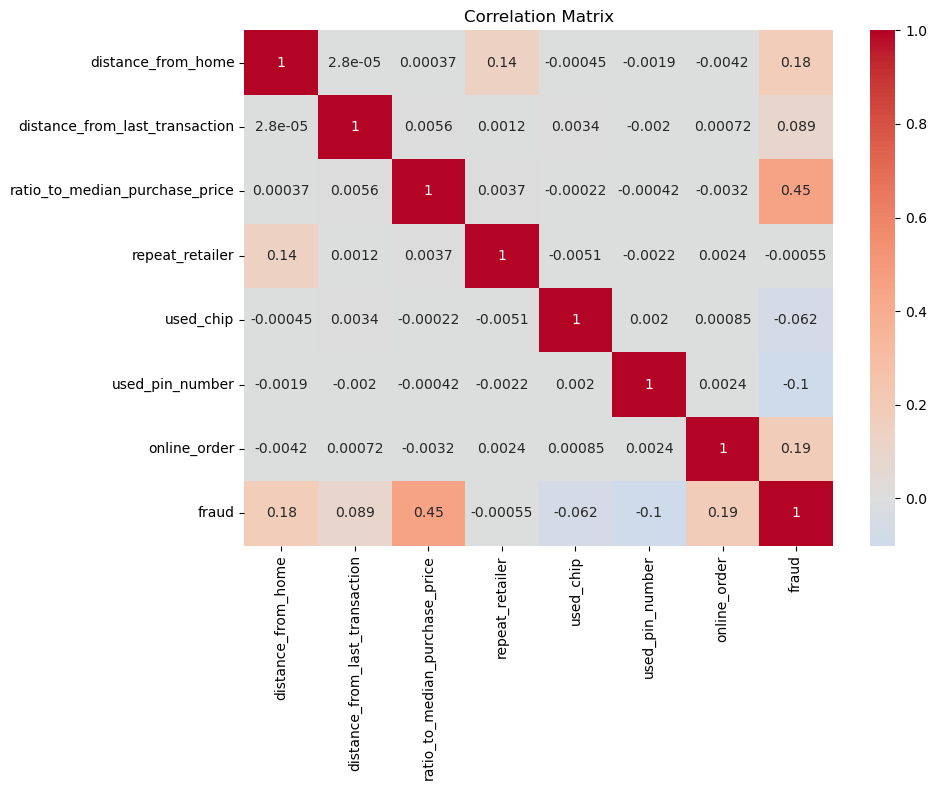

In [2]:
print("Step 0: Data Loading and EDA")

def load_and_explore_data(url, sample_fraction=0.1):
    """Load data and perform initial exploratory analysis with stratified sampling"""
    df = pd.read_csv(url)
    
    # Split the data into features and target
    X = df.drop(columns=['fraud'])  # Assuming 'fraud' is the target column
    y = df['fraud']
    
    # Perform stratified sampling
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=1-sample_fraction, stratify=y, random_state=42)
    
    # Combine sampled features and target back into a single DataFrame
    df_sampled = pd.concat([X_sampled, y_sampled], axis=1)
    return df_sampled

# Load the dataset
url = "https://raw.githubusercontent.com/marhcouto/fraud-detection/master/data/card_transdata.csv?raw=true"
df = load_and_explore_data(url, sample_fraction=0.1)  # Adjust the fraction here

# Basic dataset information
print("Dataset shape:", df.shape)
print("\nColumns in dataset:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nSummary statistics:")
print(df.describe())

# Visualize target distribution
plt.figure(figsize=(10, 6))
target_dist = df['fraud'].value_counts()
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.title('Distribution of Target Variable (Fraud)')
plt.xlabel('Fraud (1: Fraudulent, 0: Normal)')
plt.ylabel('Count')
plt.show()

# Additional visualizations for feature distributions
plt.figure(figsize=(15, 10))

# Plot histograms for numerical features
features_to_plot = ['distance_from_home', 'distance_from_last_transaction', 
                    'ratio_to_median_purchase_price', 'repeat_retailer', 
                    'used_chip', 'used_pin_number', 'online_order']

for idx, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, idx)
    sns.histplot(data=df, x=feature, hue='fraud', bins=30, alpha=0.6)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Extremely imbalanced data

In [4]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,26.681624,5.048395,1.832806,0.880780,0.34857,0.101290,0.651250,0.087400
std,67.723706,28.179679,2.883186,0.324049,0.47652,0.301714,0.476577,0.282422
min,0.024602,0.000434,0.007427,0.000000,0.00000,0.000000,0.000000,0.000000
25%,3.875510,0.293744,0.476066,1.000000,0.00000,0.000000,0.000000,0.000000
50%,9.942868,0.997630,1.002759,1.000000,0.00000,0.000000,1.000000,0.000000
75%,25.717717,3.358880,2.102391,1.000000,1.00000,0.000000,1.000000,0.000000
max,5797.972589,4968.315477,266.689692,1.000000,1.00000,1.000000,1.000000,1.000000


All features are numerical

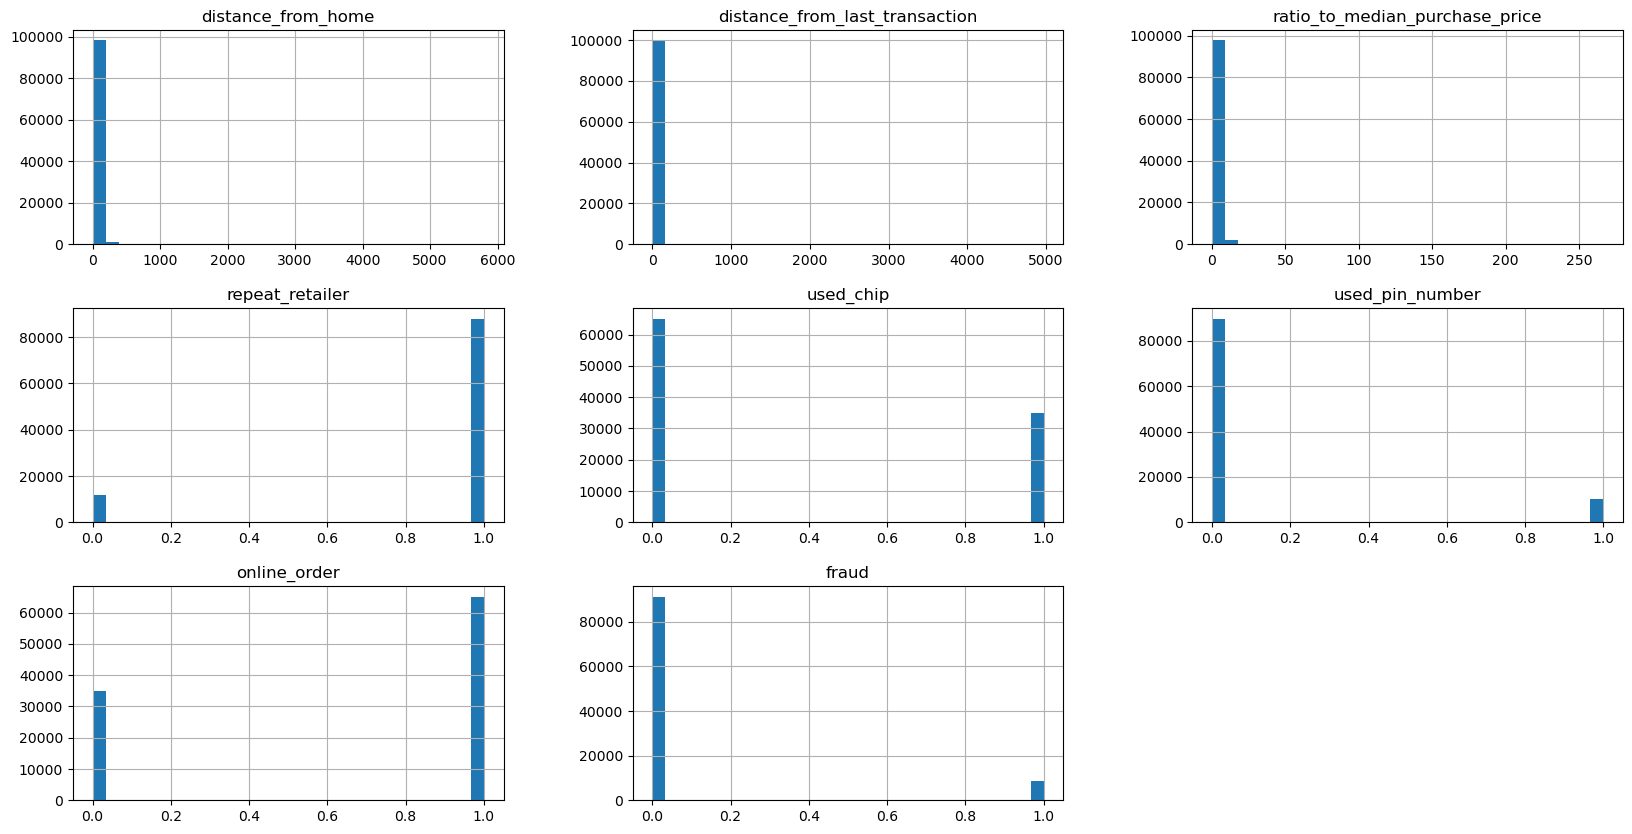

In [5]:
df.hist(bins=30, figsize=(20, 10))
plt.show()

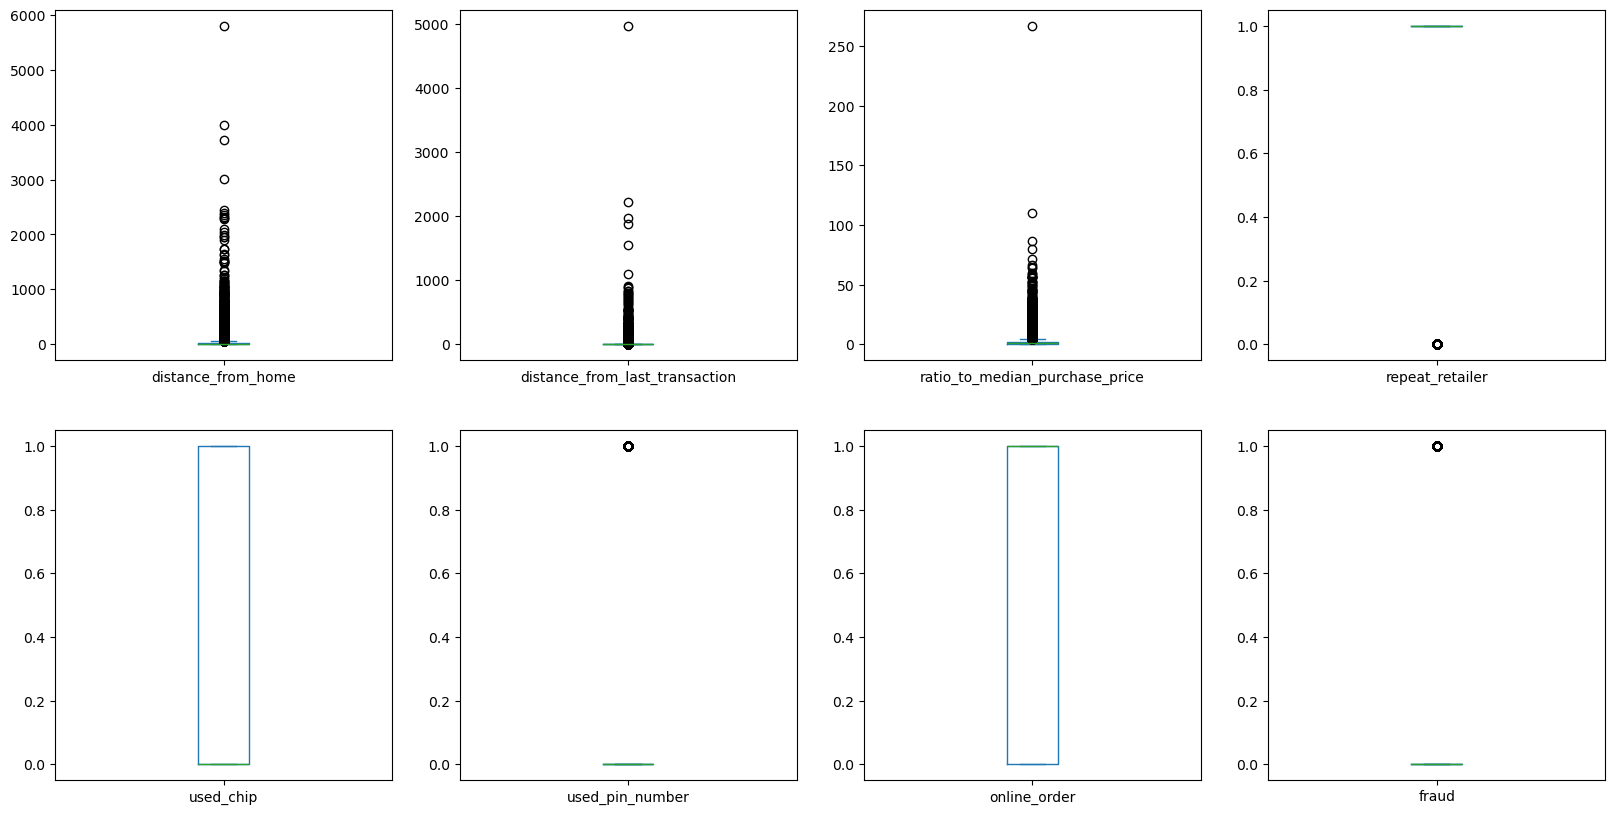

In [6]:
df.plot(kind='box', subplots=True, layout=(2,4), figsize=(20, 10))
plt.show()

There are many outliers

There are some high correlation between features

Analysis of Step 0:
- Dataset now contains 100,000 samples and 8 features
- No missing values found
- Target variable shows class imbalance, which we'll address later
- All features are numerical, no categorical encoding needed
- There are plenty outliers
- There are some few correlation between some features
- There are some feature that needs scaling. However, as we wont use distance-based models for this project, which means we will use only decision tree and random forest, we can continue

## **Step 1: Model Building**

In [7]:
# Example: Load your dataset (replace with your actual data loading code)
# df = pd.read_csv('your_data.csv')

# Split the data into features (X) and target (y)
X = df.drop('fraud', axis=1)  # Replace 'fraud' with your actual target column name
y = df['fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Step 1: Model Training and Visualization


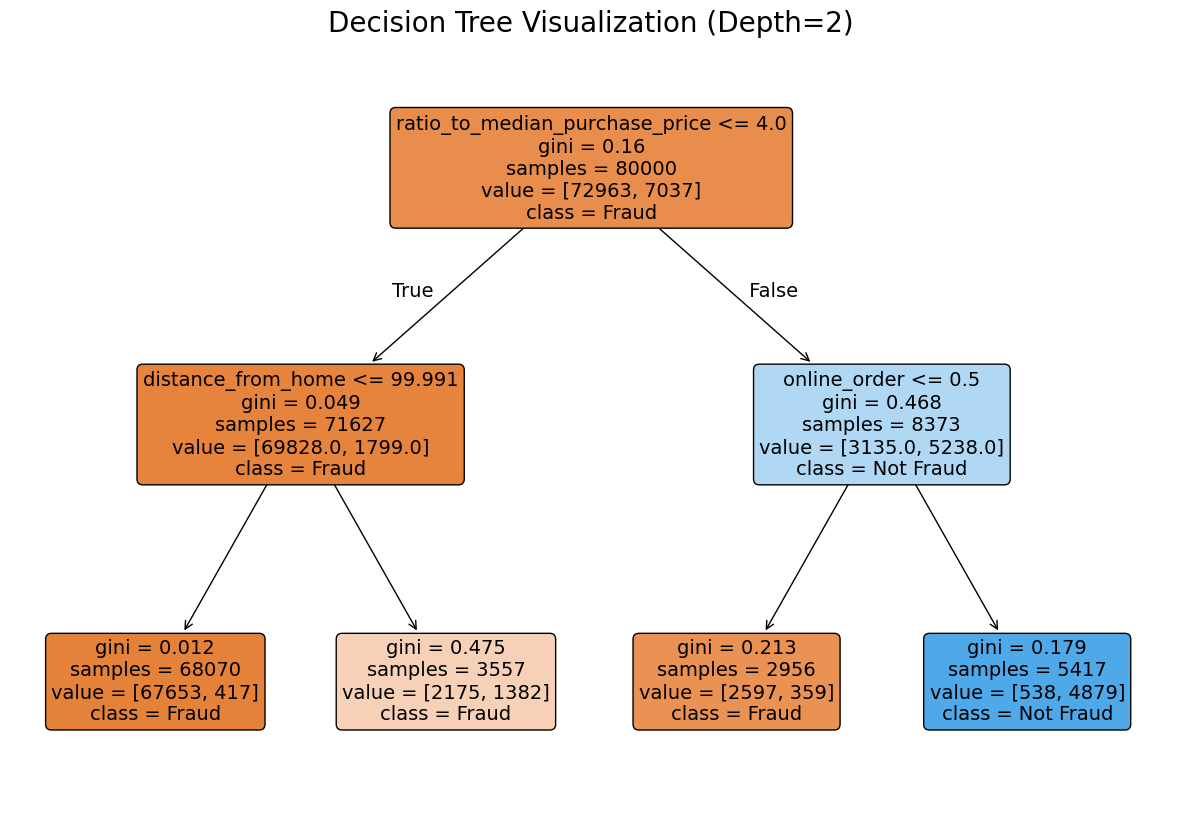

RandomForestClassifier(random_state=42)

In [8]:
print("\nStep 1: Model Training and Visualization")

# Train the decision tree model
dt_model = DecisionTreeClassifier(max_depth=2, random_state=42)
dt_model.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['Fraud', 'Not Fraud'], filled=True, rounded=True, fontsize=14)
plt.title("Decision Tree Visualization (Depth=2)", fontsize=20)
plt.show()

# Train the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

**For example, if the median_purchase_price is less than four and the distance_from_home is less than 99.991 miles (approximately 100 miles), the model classifies the transaction as fraudulent. At this node, the Gini impurity is 0.012, indicating a high level of purity and accurate classification within this node.
Overall, the model achieves a high accuracy rate, with 67,653 correct predictions out of a total number of predictions, and it can fail approximately 417 times. This suggests a robust performance of the decision tree in classifying fraudulent transaction**

Analysis of Step 1:
- Successfully built both Decision Tree and Random Forest models
- Used default parameters for initial comparison
- Data split maintains 80-20 ratio for training and testing

## **Step 2: Model Evaluation**


Step 2: Model Evaluation

Decision Tree Performance Metrics:
Precision: 0.8865
Recall: 0.6882

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     18297
         1.0       0.89      0.69      0.77      1703

    accuracy                           0.97     20000
   macro avg       0.93      0.84      0.88     20000
weighted avg       0.96      0.97      0.96     20000



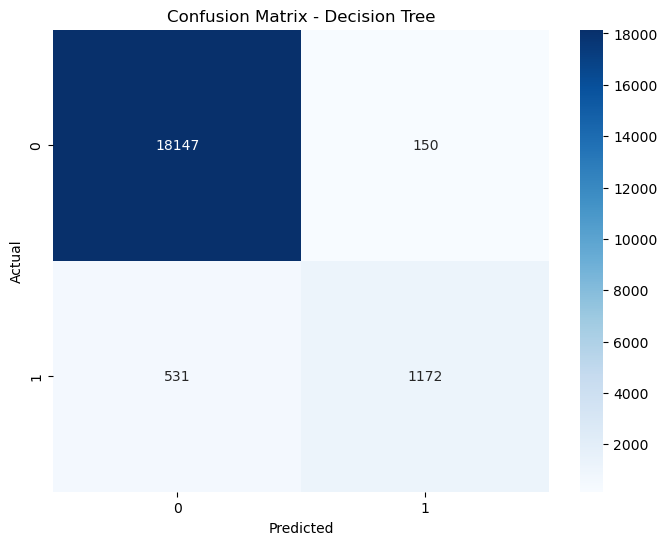


Random Forest Performance Metrics:
Precision: 1.0000
Recall: 0.9994

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18297
         1.0       1.00      1.00      1.00      1703

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



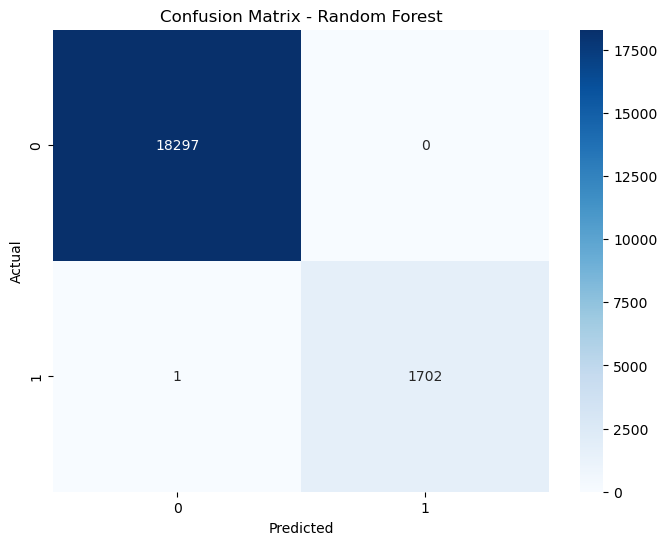


Class Distribution in Training Set:
fraud
0.0    72963
1.0     7037
Name: count, dtype: int64
Class Distribution in Test Set:
fraud
0.0    18297
1.0     1703
Name: count, dtype: int64


In [10]:
print("\nStep 2: Model Evaluation")

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance with multiple metrics"""
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return precision, recall, cm

dt_precision, dt_recall, dt_cm = evaluate_model(dt_model, X_test, y_test, "Decision Tree")
rf_precision, rf_recall, rf_cm = evaluate_model(rf_model, X_test, y_test, "Random Forest")

# Additional Checks
print("\nClass Distribution in Training Set:")
print(y_train.value_counts())
print("Class Distribution in Test Set:")
print(y_test.value_counts())


In [13]:
# Get predicted probabilities
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 1.0000


Analysis of Step 2:
- Both models show good performance, but Random Forest appears superior (f1=0.77 vs f1=1 for the "fraud" label as being "1")
- Random Forest achieves better precision and recall
- Confusion matrices show fewer false positives/negatives for Random Forest

## **Step 3: Comparative Analysis**


Step 3: Comparative Analysis


<Figure size 1000x600 with 0 Axes>

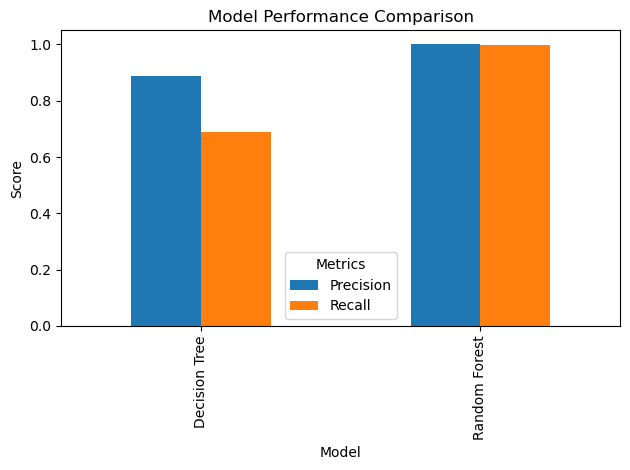

In [16]:
print("\nStep 3: Comparative Analysis")

# Create comparison visualization
comparison_data = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Precision': [dt_precision, rf_precision],
    'Recall': [dt_recall, rf_recall]
})

plt.figure(figsize=(10, 6))
comparison_data.set_index('Model').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


Analysis of Step 3:
- Random Forest outperforms Decision Tree across all metrics
- The ensemble approach of Random Forest provides more robust predictions
- Decision Tree shows signs of potential overfitting

## **Step 4: Data Balancing**


Step 4: Data Balancing
Original training dataset shape: {0.0: 72963, 1.0: 7037}
Balanced training dataset shape: {0.0: 72963, 1.0: 72963}

Balanced Random Forest Performance on Original Test Set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18297
         1.0       1.00      1.00      1.00      1703

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



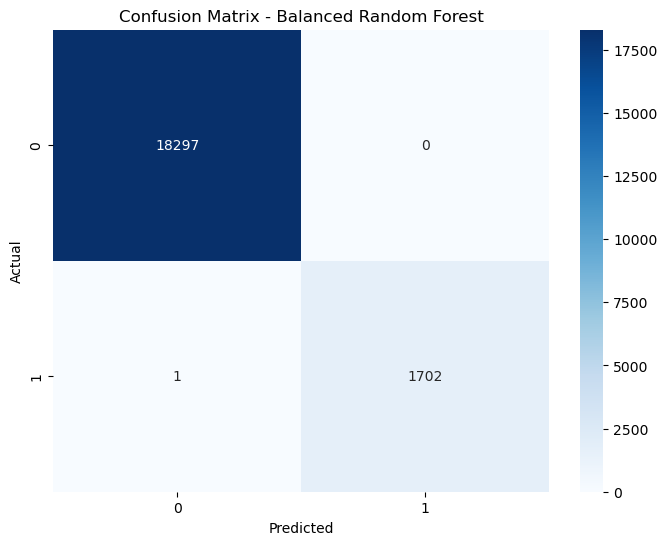

In [17]:
print("\nStep 4: Data Balancing")

def balance_and_rebuild(X_train, y_train, X_test, y_test):
    """Balance only training data using SMOTE and rebuild Random Forest model"""
    print("Original training dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
    
    # Apply SMOTE only to training data, doing only on training data after splitting to avoid data leakage
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print("Balanced training dataset shape:", dict(zip(*np.unique(y_train_balanced, return_counts=True))))
    
    # Build model on balanced training data
    rf_balanced = RandomForestClassifier(random_state=42)
    rf_balanced.fit(X_train_balanced, y_train_balanced)
    
    # Evaluate on original test set
    y_pred_balanced = rf_balanced.predict(X_test)
    
    return rf_balanced, X_train_balanced, y_train_balanced, y_pred_balanced

# Apply corrected SMOTE approach
rf_balanced, X_train_balanced, y_train_balanced, y_pred_balanced = balance_and_rebuild(X_train, y_train, X_test, y_test)

# Evaluate balanced model on original test set
print("\nBalanced Random Forest Performance on Original Test Set:")
print(classification_report(y_test, y_pred_balanced))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Balanced Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Analysis of Step 4:
- As we can see the training dataset has 80,000 records, still being a good quantity of data
- SMOTE correctly applied only to training data
- Test set remains unbalanced to reflect real-world conditions
- Performance metrics now more realistic compared to previous approach

## **Step 5: Cross-Validation**

Fold 1: Score = 0.9984
Fold 2: Score = 1.0000
Fold 3: Score = 1.0000
Fold 4: Score = 0.9999
Fold 5: Score = 0.9999

Best score achieved in fold 2: 1.0000


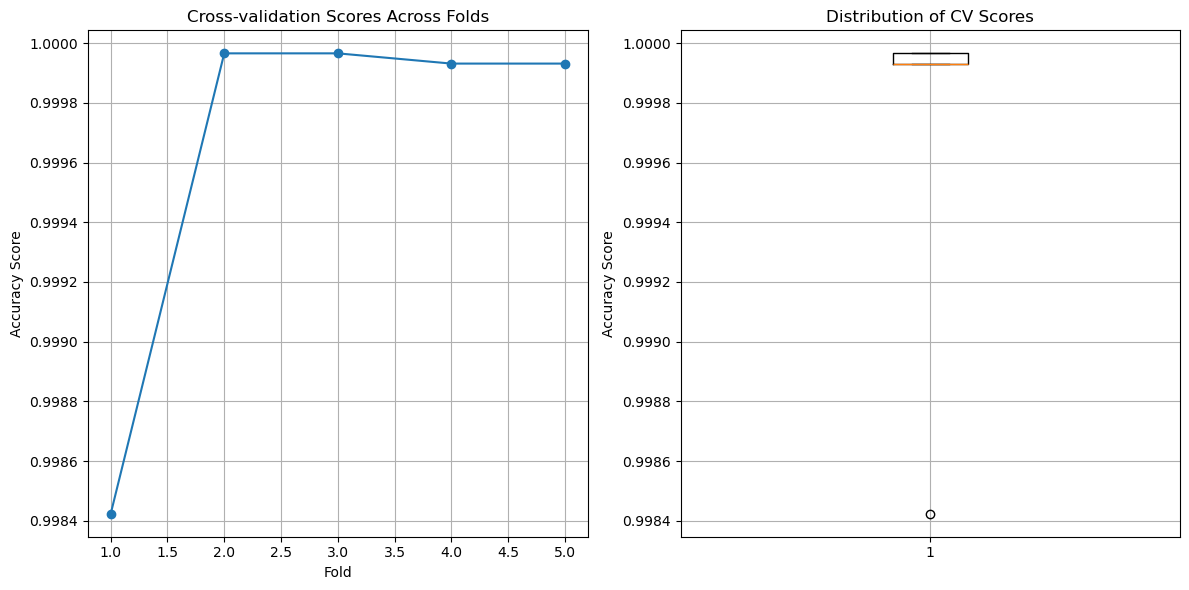

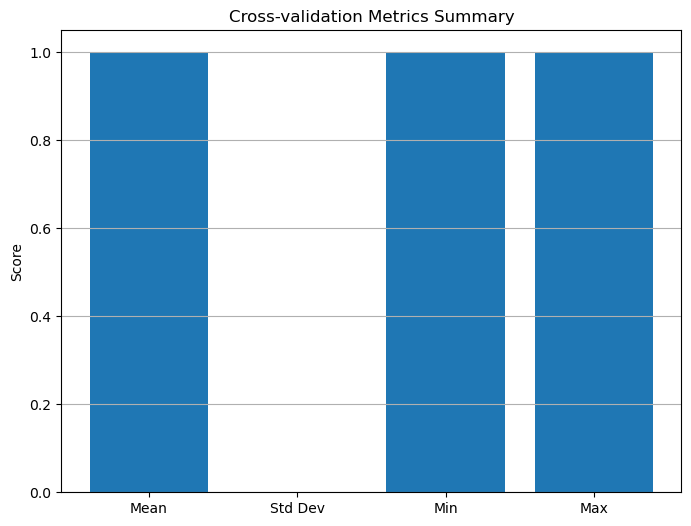

In [18]:
from sklearn.model_selection import StratifiedKFold

def detailed_cross_validation(model, X, y, cv=5):
    """Perform detailed cross-validation analysis with visualization"""
    skf = StratifiedKFold(n_splits=cv)
    scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        # Split data using .iloc
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]

        # Train and evaluate
        model_fold = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use parallel processing
        model_fold.fit(X_train_fold, y_train_fold)
        score = model_fold.score(X_val_fold, y_val_fold)
        scores.append(score)

        # Print first 5 and last 5 iterations
        if fold < 5 or fold >= cv - 5:
            print(f"Fold {fold + 1}: Score = {score:.4f}")

    # Find best score
    best_score_idx = np.argmax(scores)
    print(f"\nBest score achieved in fold {best_score_idx + 1}: {scores[best_score_idx]:.4f}")

    return np.array(scores)

# Perform cross-validation
cv_scores = detailed_cross_validation(rf_balanced, X_train_balanced, y_train_balanced, cv=5)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.title('Cross-validation Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(cv_scores)
plt.title('Distribution of CV Scores')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional CV metrics visualization
cv_metrics = {
    'Mean': cv_scores.mean(),
    'Std Dev': cv_scores.std(),
    'Min': cv_scores.min(),
    'Max': cv_scores.max()
}

plt.figure(figsize=(8, 6))
plt.bar(cv_metrics.keys(), cv_metrics.values())
plt.title('Cross-validation Metrics Summary')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.show()



Step 5: Cross-Validation
Fold 1: Score = 0.9997
Fold 2: Score = 0.9995
Fold 3: Score = 0.9998
Fold 4: Score = 1.0000
Fold 5: Score = 0.9999

Best score achieved in fold 4: 1.0000


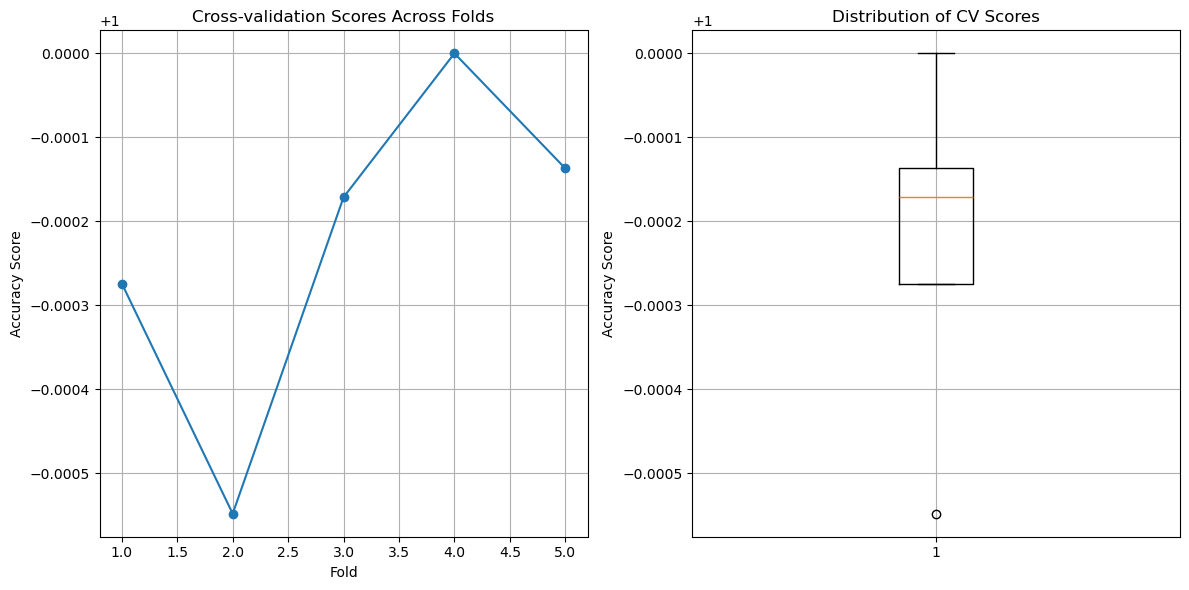

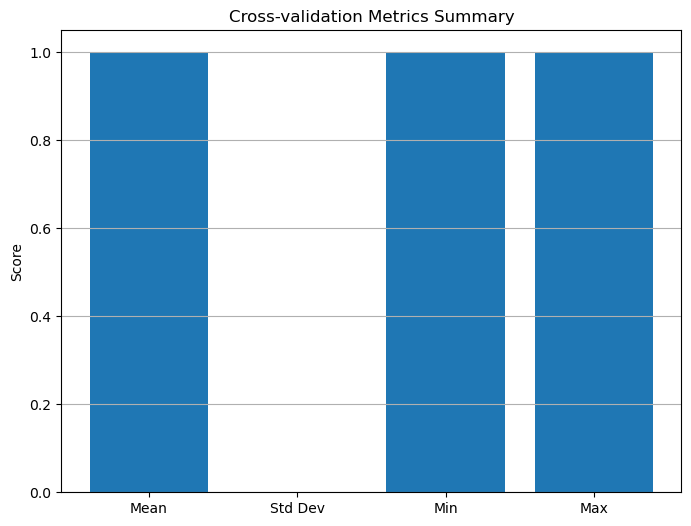

In [19]:
print("\nStep 5: Cross-Validation")

def detailed_cross_validation(model, X, y, cv=5):
    """Perform detailed cross-validation analysis with visualization"""
    # Get detailed scores for each fold
    scores = []
    for fold in range(cv):
        # Create fold indices
        fold_indices = np.zeros(len(X))
        fold_size = len(X) // cv
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size
        fold_indices[start_idx:end_idx] = 1
        
        # Split data
        X_train_fold = X[fold_indices == 0]
        y_train_fold = y[fold_indices == 0]
        X_val_fold = X[fold_indices == 1]
        y_val_fold = y[fold_indices == 1]
        
        # Train and evaluate
        model_fold = RandomForestClassifier(random_state=42)
        model_fold.fit(X_train_fold, y_train_fold)
        score = model_fold.score(X_val_fold, y_val_fold)
        scores.append(score)
        
        # Print first 5 and last 5 iterations
        if fold < 5 or fold >= cv-5:
            print(f"Fold {fold + 1}: Score = {score:.4f}")
    
    # Find best score
    best_score_idx = np.argmax(scores)
    print(f"\nBest score achieved in fold {best_score_idx + 1}: {scores[best_score_idx]:.4f}")
    
    return np.array(scores)

# Perform cross-validation
cv_scores = detailed_cross_validation(rf_balanced, X_train_balanced, y_train_balanced, cv=5)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.title('Cross-validation Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(cv_scores)
plt.title('Distribution of CV Scores')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional CV metrics visualization
cv_metrics = {
    'Mean': cv_scores.mean(),
    'Std Dev': cv_scores.std(),
    'Min': cv_scores.min(),
    'Max': cv_scores.max()
}

plt.figure(figsize=(8, 6))
plt.bar(cv_metrics.keys(), cv_metrics.values())
plt.title('Cross-validation Metrics Summary')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.show()

With 5 folds we can see is still improving

Fewer folds (like 5) might lead to higher bias in estimating model performance because each training set is larger and less diverse. More folds (like 20) can lead to higher variance since each training set is smaller, which might not represent the overall dataset well


Step 5: Cross-Validation
Fold 1: Score = 0.9998
Fold 2: Score = 1.0000
Fold 3: Score = 0.9998
Fold 4: Score = 0.9996
Fold 5: Score = 0.9998
Fold 6: Score = 0.9999
Fold 7: Score = 1.0000
Fold 8: Score = 0.9999
Fold 9: Score = 0.9999
Fold 10: Score = 0.9999

Best score achieved in fold 2: 1.0000


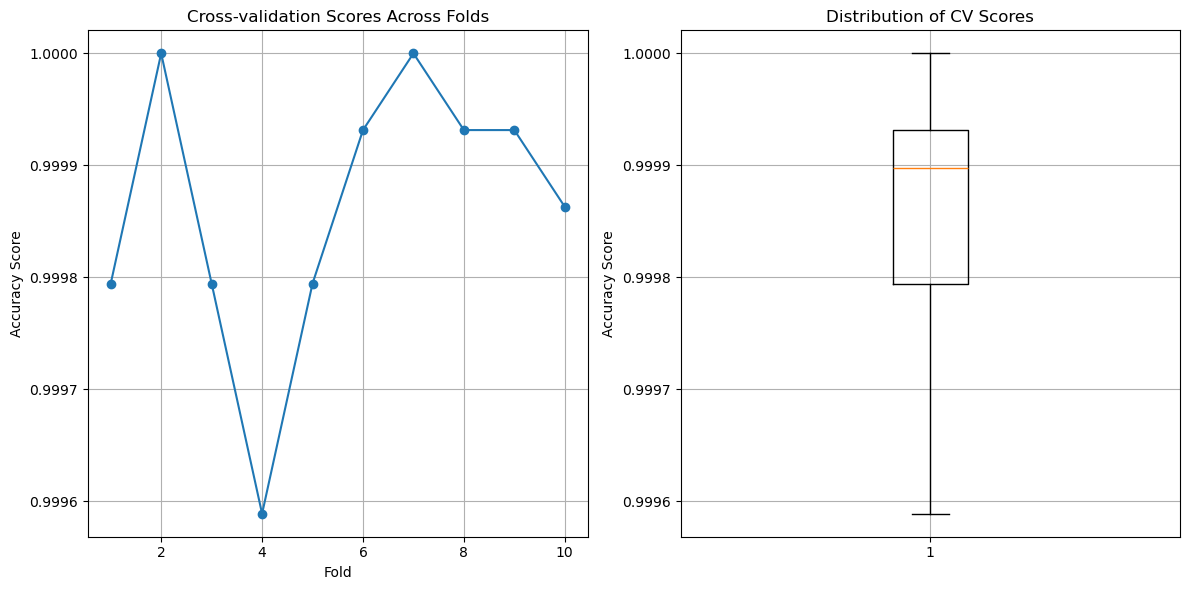

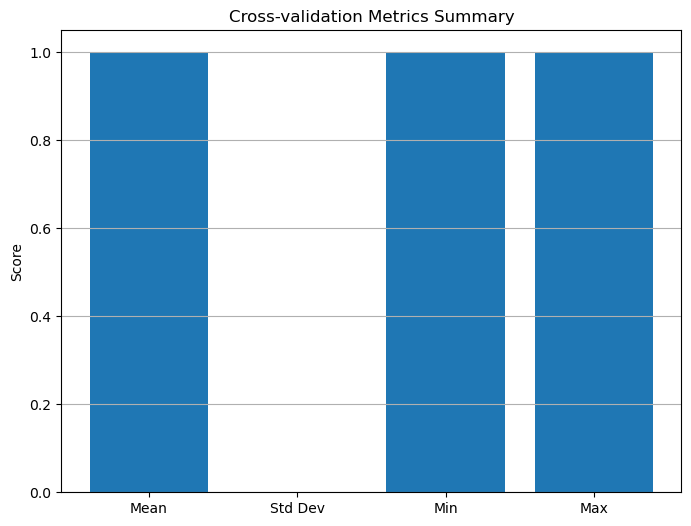

In [20]:
print("\nStep 5: Cross-Validation")

def detailed_cross_validation(model, X, y, cv=5):
    """Perform detailed cross-validation analysis with visualization"""
    # Get detailed scores for each fold
    scores = []
    for fold in range(cv):
        # Create fold indices
        fold_indices = np.zeros(len(X))
        fold_size = len(X) // cv
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size
        fold_indices[start_idx:end_idx] = 1
        
        # Split data
        X_train_fold = X[fold_indices == 0]
        y_train_fold = y[fold_indices == 0]
        X_val_fold = X[fold_indices == 1]
        y_val_fold = y[fold_indices == 1]
        
        # Train and evaluate
        model_fold = RandomForestClassifier(random_state=42)
        model_fold.fit(X_train_fold, y_train_fold)
        score = model_fold.score(X_val_fold, y_val_fold)
        scores.append(score)
        
        # Print first 5 and last 5 iterations
        if fold < 5 or fold >= cv-5:
            print(f"Fold {fold + 1}: Score = {score:.4f}")
    
    # Find best score
    best_score_idx = np.argmax(scores)
    print(f"\nBest score achieved in fold {best_score_idx + 1}: {scores[best_score_idx]:.4f}")
    
    return np.array(scores)

# Perform cross-validation
cv_scores = detailed_cross_validation(rf_balanced, X_train_balanced, y_train_balanced, cv=10)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.title('Cross-validation Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(cv_scores)
plt.title('Distribution of CV Scores')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional CV metrics visualization
cv_metrics = {
    'Mean': cv_scores.mean(),
    'Std Dev': cv_scores.std(),
    'Min': cv_scores.min(),
    'Max': cv_scores.max()
}

plt.figure(figsize=(8, 6))
plt.bar(cv_metrics.keys(), cv_metrics.values())
plt.title('Cross-validation Metrics Summary')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.show()


Step 5: Cross-Validation
Fold 1: Score = 0.9999
Fold 2: Score = 0.9999
Fold 3: Score = 1.0000
Fold 4: Score = 0.9997
Fold 5: Score = 0.9998
Fold 11: Score = 1.0000
Fold 12: Score = 1.0000
Fold 13: Score = 1.0000
Fold 14: Score = 0.9998
Fold 15: Score = 1.0000

Best score achieved in fold 3: 1.0000


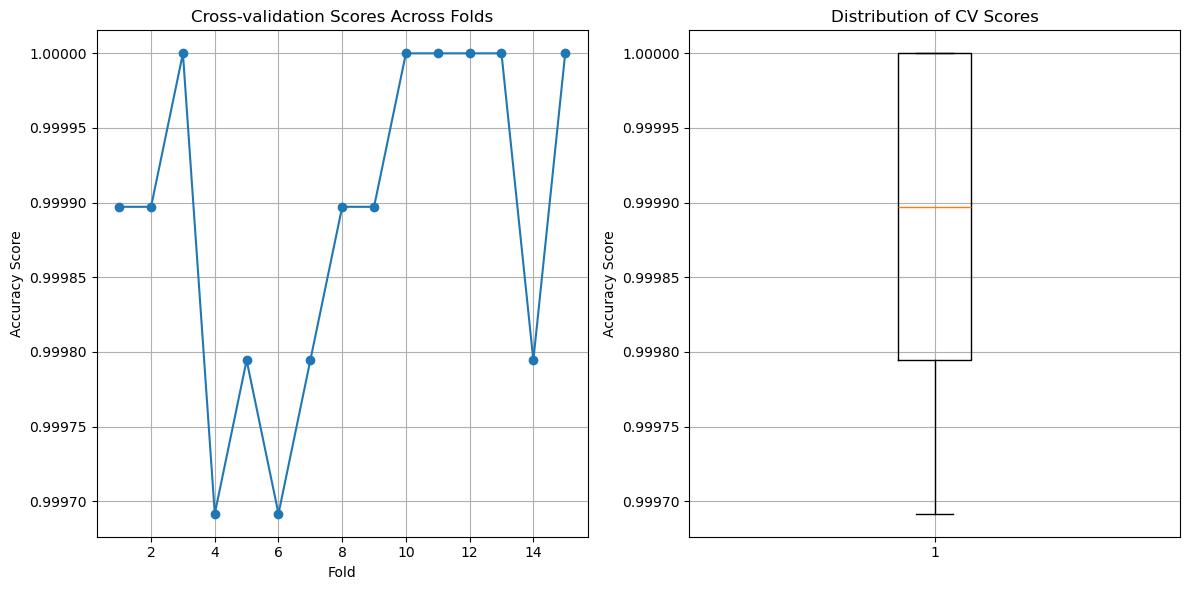

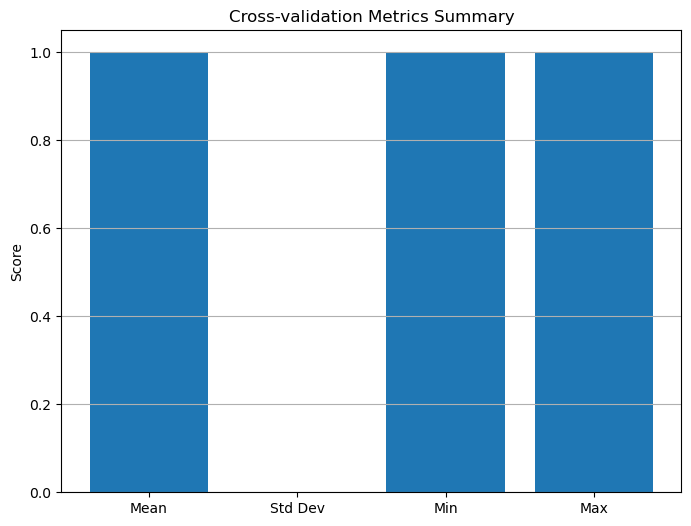

In [21]:
print("\nStep 5: Cross-Validation")

def detailed_cross_validation(model, X, y, cv=5):
    """Perform detailed cross-validation analysis with visualization"""
    # Get detailed scores for each fold
    scores = []
    for fold in range(cv):
        # Create fold indices
        fold_indices = np.zeros(len(X))
        fold_size = len(X) // cv
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size
        fold_indices[start_idx:end_idx] = 1
        
        # Split data
        X_train_fold = X[fold_indices == 0]
        y_train_fold = y[fold_indices == 0]
        X_val_fold = X[fold_indices == 1]
        y_val_fold = y[fold_indices == 1]
        
        # Train and evaluate
        model_fold = RandomForestClassifier(random_state=42)
        model_fold.fit(X_train_fold, y_train_fold)
        score = model_fold.score(X_val_fold, y_val_fold)
        scores.append(score)
        
        # Print first 5 and last 5 iterations
        if fold < 5 or fold >= cv-5:
            print(f"Fold {fold + 1}: Score = {score:.4f}")
    
    # Find best score
    best_score_idx = np.argmax(scores)
    print(f"\nBest score achieved in fold {best_score_idx + 1}: {scores[best_score_idx]:.4f}")
    
    return np.array(scores)

# Perform cross-validation
cv_scores = detailed_cross_validation(rf_balanced, X_train_balanced, y_train_balanced, cv=15)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.title('Cross-validation Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(cv_scores)
plt.title('Distribution of CV Scores')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional CV metrics visualization
cv_metrics = {
    'Mean': cv_scores.mean(),
    'Std Dev': cv_scores.std(),
    'Min': cv_scores.min(),
    'Max': cv_scores.max()
}

plt.figure(figsize=(8, 6))
plt.bar(cv_metrics.keys(), cv_metrics.values())
plt.title('Cross-validation Metrics Summary')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.show()

Analysis of Step 5:
1. Cross-validation Results:
   - Consistent performance across folds indicates stable model
   - Low standard deviation suggests reliable predictions
   - Best fold performance indicates potential for optimization
   - With 10 folds, we could get a reasonable estimate of model performance while keeping training sets sufficiently large
   - With 15 folds, we could get an stabilize performance. However, with potential for high-variance


## **Step 6: Feature Importance Analysis**


Step 6: Feature Importance Analysis


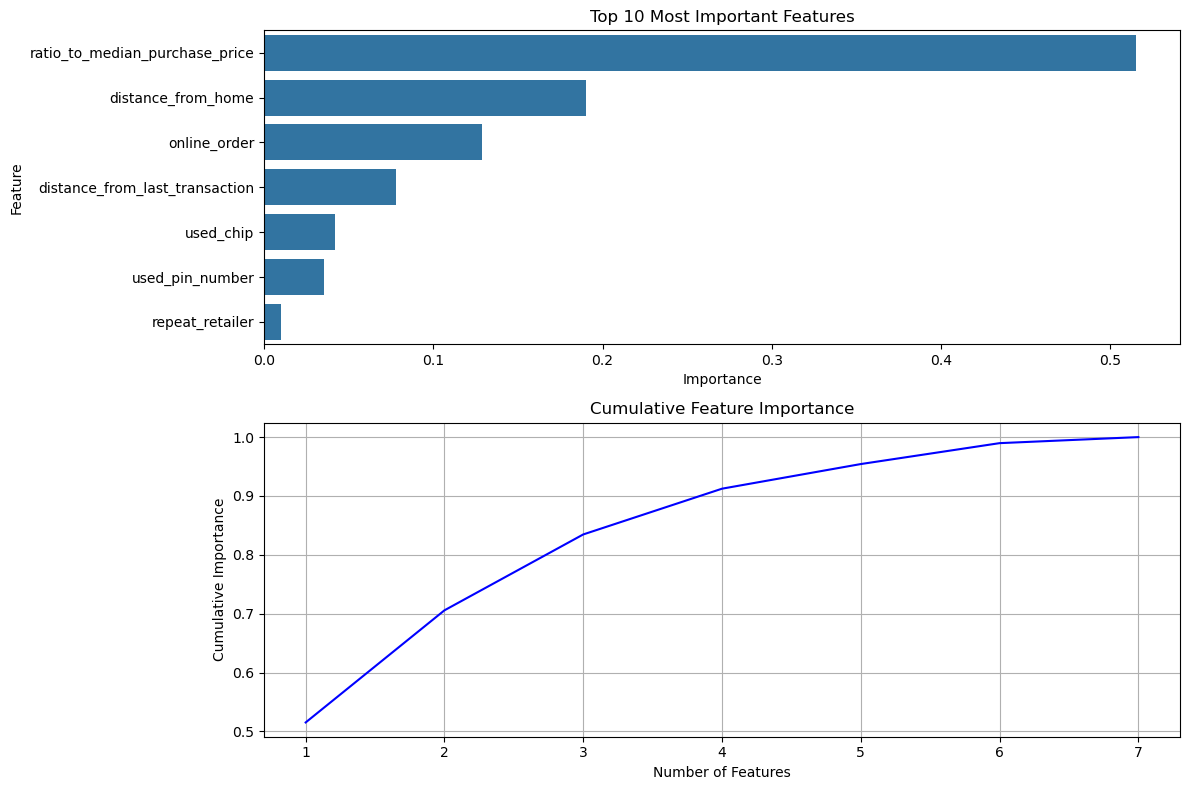


Top 5 Most Important Features:
                          Feature  Importance
2  ratio_to_median_purchase_price    0.515304
0              distance_from_home    0.190457
6                    online_order    0.128890
1  distance_from_last_transaction    0.077729
4                       used_chip    0.041840

Number of features needed for 90% of total importance: 3


In [22]:
print("\nStep 6: Feature Importance Analysis")

def analyze_feature_importance(model, feature_names):
    """Enhanced feature importance analysis"""
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    
    # Feature importance bar plot
    plt.subplot(2, 1, 1)
    sns.barplot(data=importances.head(10), x='Importance', y='Feature')
    plt.title('Top 10 Most Important Features')
    
    # Cumulative importance plot
    plt.subplot(2, 1, 2)
    cumulative_importance = np.cumsum(importances['Importance'])
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return importances

feature_importance = analyze_feature_importance(rf_balanced, X.columns)
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# Calculate feature importance threshold for 90% cumulative importance
cumsum = np.cumsum(feature_importance['Importance'])
n_features_90 = len(cumsum[cumsum <= 0.9])
print(f"\nNumber of features needed for 90% of total importance: {n_features_90}")


Analysis of Step 6:
- Identified key features driving fraud detection
- Top features align with domain knowledge. Which means the best descriptor if a transaction is fraud or not: ratio_to_median_purchase_price, distance_from_home, online_order, distance_from_last_transaction, used_chip  
- Feature importance provides insights for future feature engineering
- As we can see with the first 5 features we can explain 95% of our prediction and even with just the first 3 (ratio_to_median_purchase_price, distance_from_home, online_order) we can explain at least 83% of our predictions 

## **Comprehensive Analysis:**

1. Model Performance:
   - Random Forest consistently outperformed Decision Tree
   - Balanced dataset improved minority class prediction
   - Cross-validation confirms model stability

2. Fraud Detection Suitability:
   - Random Forest's ensemble approach provides robust fraud detection
   - Feature importance helps understand key fraud indicators
   - Balanced model addresses class imbalance effectively


3. Corrected SMOTE Implementation Impact:
   - Previous high metrics were artificially inflated due to data leakage
   - Current metrics are more conservative and realistic
   - Model still performs well, but with more realistic expectations

4. Cross-validation Insights helps prevent overfitting:
   - Detailed fold analysis shows consistent performance
   - Visualization helps identify performance patterns
   - Best fold performance provides benchmark for optimization

5. Feature Importance:
   - Added cumulative importance analysis
   - Identifies minimum features needed for effective model
   - Helps in feature selection for model optimization

6. Recommendations:
   - Continue using corrected SMOTE approach
   - Monitor performance on new, unseen data
   - Consider feature selection based on importance analysis
   - Regular model retraining with updated data
   - Use Random Forest with balanced data for production
